# Brain Tumor MRI Classification — Multi-head Hierarchical Training (Clean, No Contamination)

This notebook trains a **multi-head hierarchical** model:

- **Head A (Detection):** tumor vs no_tumor  
- **Head B (Subtype):** glioma / meningioma / pituitary (only meaningful if tumor)

It is designed to:
- avoid **train/eval contamination** (external `Eval/` is never used for selection)
- reduce **shortcut learning** (e.g., skull rim / border cues) via brain cropping
- provide **better visual outputs** (confusion heatmaps, per-class recall, Grad-CAM, occlusion)
- work in **Google Colab** (but also locally)

Dataset layout expected:

```
BrainTumor/
  Training/<4 class folders>/*
  Testing/<4 class folders>/*
  Eval/<4 class folders>/*          (optional external holdout, never used for selection)
```

> With ~800 images per class, **transfer learning** is usually the difference between “works” and “doesn’t”.
This notebook uses a pretrained backbone by default, but you can disable it.


In [ ]:
# ============================================================
# 0) Setup (Colab-friendly, avoids common Pillow/torchvision issues)
# ============================================================
import os, sys, math, time, random, zipfile, glob, hashlib
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules

def _pip_install(pkgs):
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

# Colab sometimes breaks torchvision if Pillow is too new.
def _ensure_colab_compat():
    if not IN_COLAB:
        return
    try:
        from packaging import version
    except Exception:
        _pip_install(["packaging"])
        from packaging import version
    try:
        import PIL
        pil_v = version.parse(PIL.__version__)
    except Exception:
        pil_v = None

    fixes = []
    if pil_v is not None and pil_v >= version.parse("12.0.0"):
        fixes.append("pillow==11.3.0")

    if fixes:
        print("Applying compatibility pins:", fixes)
        _pip_install(["--force-reinstall", "--no-cache-dir"] + fixes)

_ensure_colab_compat()

# core deps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset

from torchvision import transforms
from torchvision.datasets import ImageFolder

# metrics
try:
    from sklearn.model_selection import StratifiedShuffleSplit
    from sklearn.metrics import (
        confusion_matrix, classification_report,
        accuracy_score, balanced_accuracy_score,
        precision_recall_fscore_support, f1_score
    )
except Exception:
    _pip_install(["scikit-learn"])
    from sklearn.model_selection import StratifiedShuffleSplit
    from sklearn.metrics import (
        confusion_matrix, classification_report,
        accuracy_score, balanced_accuracy_score,
        precision_recall_fscore_support, f1_score
    )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.benchmark = True


Device: cuda


In [ ]:
# ============================================================
# 1) Locate dataset (Drive mount + zip auto-detect)
# ============================================================
def _try_mount_drive():
    if not IN_COLAB:
        return False
    try:
        from google.colab import drive
        drive.mount("/content/drive")
        return True
    except Exception as e:
        print("Drive mount skipped:", e)
        return False

_ = _try_mount_drive()

def find_dataset_root(search_roots, max_depth=6):
    search_roots = [Path(p) for p in search_roots if Path(p).exists()]
    for root in search_roots:
        for cur, dirs, files in os.walk(root):
            curp = Path(cur)
            depth = len(curp.relative_to(root).parts)
            if depth > max_depth:
                dirs[:] = []
                continue
            if (curp / "Training").is_dir() and (curp / "Testing").is_dir():
                return curp
    return None

def find_zip(search_roots):
    patterns = ["*tumor*.zip", "*BrainTumor*.zip", "*brain*.zip", "*mri*.zip", "*.zip"]
    best = None
    for root in map(Path, search_roots):
        if not root.exists():
            continue
        for pat in patterns:
            for z in root.glob(pat):
                if not z.is_file():
                    continue
                try:
                    with zipfile.ZipFile(z, "r") as zf:
                        names = [n.lower() for n in zf.namelist()]
                    has_train = any("/training/" in n or n.endswith("training/") for n in names)
                    has_test  = any("/testing/"  in n or n.endswith("testing/")  for n in names)
                    score = int(has_train) + int(has_test)
                    if score == 0:
                        continue
                    cand = (score, z.stat().st_size, str(z))
                    if best is None or cand > best:
                        best = cand
                except Exception:
                    pass
    return Path(best[2]) if best else None

SEARCH_ROOTS = ["/content", "/content/drive/MyDrive", "/content/drive"]
dataset_root = find_dataset_root(SEARCH_ROOTS)

if dataset_root is None:
    z = find_zip(SEARCH_ROOTS)
    if z is not None:
        print("Found zip:", z)
        out = Path("/content/BrainTumor")
        out.mkdir(parents=True, exist_ok=True)
        with zipfile.ZipFile(z, "r") as zf:
            zf.extractall(out)
        dataset_root = find_dataset_root([out], max_depth=8) or out
    else:
        if IN_COLAB:
            from google.colab import files
            print("No dataset folder/zip found. Upload a ZIP now...")
            up = files.upload()
            zname = next(iter(up.keys()))
            out = Path("/content/BrainTumor")
            out.mkdir(parents=True, exist_ok=True)
            with zipfile.ZipFile(zname, "r") as zf:
                zf.extractall(out)
            dataset_root = find_dataset_root([out], max_depth=8) or out

print("DATASET ROOT:", dataset_root)
assert dataset_root is not None, "Dataset root not found. Provide Training/ and Testing/ folders."

train_root = Path(dataset_root) / "Training"
test_root  = Path(dataset_root) / "Testing"

# optional external holdout (NEVER used for selection)
eval_root_candidates = [
    Path(dataset_root) / "Eval",
    Path(dataset_root) / "EVAL",
    Path(dataset_root) / "Holdout",
    Path(dataset_root) / "Validation",
]
eval_root = next((p for p in eval_root_candidates if p.is_dir()), None)
print("External EVAL root:", eval_root)


Mounted at /content/drive
Found zip: /content/drive/MyDrive/BrainTumor.zip
DATASET ROOT: /content/BrainTumor/BrainTumor
External EVAL root: None


In [ ]:
# ============================================================
# 2) Config
# ============================================================
IMG_SIZE = 224
EPOCHS = 25
VAL_FRACTION = 0.15
BATCH_SIZE = 64 if device.type == "cuda" else 24
NUM_WORKERS = 2 if device.type == "cuda" else 0

# IMPORTANT: With ~800 images per class, pretrained backbones help a lot.
USE_PRETRAINED = True      # set False to train from scratch (usually worse)
FREEZE_EPOCHS = 3          # train heads only at first
UNFREEZE_LAST_BLOCK_ONLY = True  # then unfreeze last block; later full unfreeze

LR_HEAD = 3e-4
LR_BACKBONE = 1e-5
WEIGHT_DECAY = 1e-3

PATIENCE = 6               # early stop on val macro_f1
GRAD_CLIP = 1.0

# detection threshold (tuned on val; never tuned on external eval)
TUMOR_TAU_INIT = 0.50

# Class order (must match folder names)
CLASSES = ["glioma_tumor", "meningioma_tumor", "pituitary_tumor", "no_tumor"]
NO_TUMOR_ID = CLASSES.index("no_tumor")
TUMOR_CLASS_IDS = [i for i in range(len(CLASSES)) if i != NO_TUMOR_ID]

print(dict(
    IMG_SIZE=IMG_SIZE, EPOCHS=EPOCHS, VAL_FRACTION=VAL_FRACTION,
    BATCH_SIZE=BATCH_SIZE, USE_PRETRAINED=USE_PRETRAINED,
))


{'IMG_SIZE': 224, 'EPOCHS': 25, 'VAL_FRACTION': 0.15, 'BATCH_SIZE': 64, 'USE_PRETRAINED': True}


In [ ]:
# ============================================================
# 3) Transforms (reduce shortcut learning)
# ============================================================
from PIL import Image, ImageOps

class BrainCropPadSquare:
    """Crops away large black borders by thresholding, then pads to square."""
    def __init__(self, thr=10, pad=8):
        self.thr = thr
        self.pad = pad

    def __call__(self, img: Image.Image) -> Image.Image:
        g = img.convert("L")
        arr = np.array(g)
        m = arr > self.thr
        if not m.any():
            s = max(img.size)
            return ImageOps.pad(img, (s, s), color=0)

        ys, xs = np.where(m)
        y0, y1 = ys.min(), ys.max()
        x0, x1 = xs.min(), xs.max()

        y0 = max(0, y0 - self.pad); y1 = min(arr.shape[0]-1, y1 + self.pad)
        x0 = max(0, x0 - self.pad); x1 = min(arr.shape[1]-1, x1 + self.pad)

        img_c = img.crop((x0, y0, x1+1, y1+1))
        s = max(img_c.size)
        return ImageOps.pad(img_c, (s, s), color=0)

class RandomGaussianNoise:
    def __init__(self, sigma=0.03, p=0.35):
        self.sigma = sigma
        self.p = p
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        if torch.rand(()) < self.p:
            x = (x + torch.randn_like(x) * self.sigma).clamp(0, 1)
        return x

MEAN = [0.5, 0.5, 0.5]
STD  = [0.25, 0.25, 0.25]

train_tfms = transforms.Compose([
    BrainCropPadSquare(thr=10, pad=10),
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.90, 1.00), ratio=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.03, 0.03), scale=(0.97, 1.03), shear=3),
    transforms.RandomAutocontrast(p=0.25),
    transforms.ToTensor(),
    RandomGaussianNoise(sigma=0.03, p=0.35),
    transforms.RandomErasing(p=0.12, scale=(0.02, 0.08), ratio=(0.4, 2.5), value="random"),
    transforms.Normalize(mean=MEAN, std=STD),
])

eval_tfms = transforms.Compose([
    BrainCropPadSquare(thr=10, pad=10),
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])


In [ ]:
# ============================================================
# 4) Data: ImageFolder + label remap + stratified train/val split
# ============================================================
class LabelRemapDataset(Dataset):
    def __init__(self, base_ds, remap):
        self.base_ds = base_ds
        self.remap = remap
        self.samples = base_ds.samples  # [(path, y), ...]
    def __len__(self):
        return len(self.base_ds)
    def __getitem__(self, idx):
        x, y = self.base_ds[idx]
        return x, self.remap[int(y)], self.samples[idx][0]

def build_imagefolder(root, tfms):
    base = ImageFolder(root=str(root), transform=tfms)
    inv = {v:k for k,v in base.class_to_idx.items()}
    base_order = [inv[i] for i in range(len(inv))]
    remap = {i: CLASSES.index(folder) for i, folder in enumerate(base_order)}
    return LabelRemapDataset(base, remap), base_order

train_ds_full, train_folder_order = build_imagefolder(train_root, train_tfms)
test_ds, test_folder_order = build_imagefolder(test_root, eval_tfms)

eval_ds = None
if eval_root is not None:
    eval_ds, eval_folder_order = build_imagefolder(eval_root, eval_tfms)

print("Train folder order:", train_folder_order)
print("Test  folder order:", test_folder_order)
if eval_ds is not None:
    print("Eval  folder order:", eval_folder_order)

y_all = np.array([train_ds_full[i][1] for i in range(len(train_ds_full))])
sss = StratifiedShuffleSplit(n_splits=1, test_size=VAL_FRACTION, random_state=SEED)
train_idx, val_idx = next(sss.split(np.zeros(len(y_all)), y_all))

train_ds = Subset(train_ds_full, train_idx)

# val ds (no augmentation)
train_base_eval = ImageFolder(root=str(train_root), transform=eval_tfms)
inv2 = {v:k for k,v in train_base_eval.class_to_idx.items()}
base_order2 = [inv2[i] for i in range(len(inv2))]
remap2 = {i: CLASSES.index(folder) for i, folder in enumerate(base_order2)}
val_ds = Subset(LabelRemapDataset(train_base_eval, remap2), val_idx)

def _collate(batch):
    xs, ys, ps = zip(*batch)
    return torch.stack(xs), torch.tensor(ys, dtype=torch.long), list(ps)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, persistent_workers=False, pin_memory=(device.type=="cuda"),
                          drop_last=True, collate_fn=_collate)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, persistent_workers=False, pin_memory=(device.type=="cuda"),
                        collate_fn=_collate)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, persistent_workers=False, pin_memory=(device.type=="cuda"),
                         collate_fn=_collate)

eval_loader = None
if eval_ds is not None:
    eval_loader = DataLoader(eval_ds, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=NUM_WORKERS, pin_memory=(device.type=="cuda"),
                             collate_fn=_collate)

print("Sizes:", dict(train=len(train_ds), val=len(val_ds), test=len(test_ds), eval=(len(eval_ds) if eval_ds else 0)))


Train folder order: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Test  folder order: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Sizes: {'train': 2439, 'val': 431, 'test': 394, 'eval': 0}


In [ ]:
# ============================================================
# 5) Leakage / contamination checks
# ============================================================
def paths_from_loader(loader):
    ps = []
    for _, _, p in loader:
        ps += p
    return ps

def md5_file(path, chunk=1<<20):
    h = hashlib.md5()
    with open(path, "rb") as f:
        while True:
            b = f.read(chunk)
            if not b:
                break
            h.update(b)
    return h.hexdigest()

def overlap_report(a_paths, b_paths, name_a="A", name_b="B", do_hash=True, max_hash=5000):
    a_set = set(map(str, a_paths))
    b_set = set(map(str, b_paths))
    inter = a_set & b_set
    print(f"[Path overlap] {name_a}∩{name_b}: {len(inter)}")
    a_base = set(Path(p).name for p in a_set)
    b_base = set(Path(p).name for p in b_set)
    print(f"[Basename overlap] {name_a}∩{name_b}: {len(a_base & b_base)} (weak signal)")

    if not do_hash:
        return

    a_list = list(a_set)[:max_hash]
    b_list = list(b_set)[:max_hash]
    print(f"Hashing up to {len(a_list)} + {len(b_list)} files for exact duplicate check...")
    a_h = {}
    for p in a_list:
        try:
            a_h.setdefault(md5_file(p), []).append(p)
        except Exception:
            pass

    dup = 0
    for p in b_list:
        try:
            h = md5_file(p)
        except Exception:
            continue
        if h in a_h:
            dup += 1
            if dup <= 5:
                print("  DUP:", p, "<->", a_h[h][0])
    print(f"[Exact duplicate files via md5] {name_a} vs {name_b}: {dup}")

train_paths = paths_from_loader(train_loader)
val_paths   = paths_from_loader(val_loader)
test_paths  = paths_from_loader(test_loader)
eval_paths  = paths_from_loader(eval_loader) if eval_loader is not None else []

overlap_report(train_paths, val_paths, "train", "val", do_hash=False)
overlap_report(train_paths, test_paths, "train", "test", do_hash=True)
if eval_loader is not None:
    overlap_report(train_paths, eval_paths, "train", "eval", do_hash=True)
    overlap_report(test_paths,  eval_paths, "test",  "eval", do_hash=True)


[Path overlap] train∩val: 0
[Basename overlap] train∩val: 0 (weak signal)
[Path overlap] train∩test: 0
[Basename overlap] train∩test: 97 (weak signal)
Hashing up to 2432 + 394 files for exact duplicate check...
  DUP: /content/BrainTumor/BrainTumor/Testing/no_tumor/image(86).jpg <-> /content/BrainTumor/BrainTumor/Training/no_tumor/image(61).jpg
  DUP: /content/BrainTumor/BrainTumor/Testing/no_tumor/image(91).jpg <-> /content/BrainTumor/BrainTumor/Training/no_tumor/image(66).jpg
  DUP: /content/BrainTumor/BrainTumor/Testing/no_tumor/image(96).jpg <-> /content/BrainTumor/BrainTumor/Training/no_tumor/image(71).jpg
  DUP: /content/BrainTumor/BrainTumor/Testing/no_tumor/image(28).jpg <-> /content/BrainTumor/BrainTumor/Training/no_tumor/image(4).jpg
  DUP: /content/BrainTumor/BrainTumor/Testing/no_tumor/image(62).jpg <-> /content/BrainTumor/BrainTumor/Training/no_tumor/image(37).jpg
[Exact duplicate files via md5] train vs test: 75


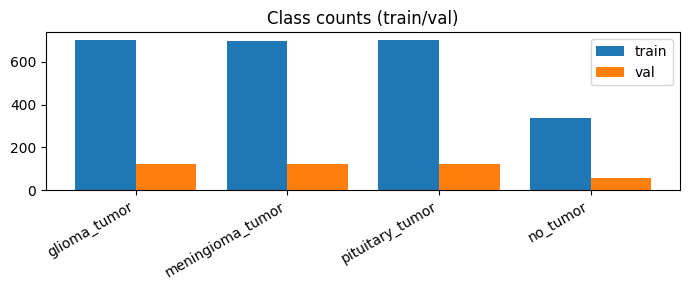

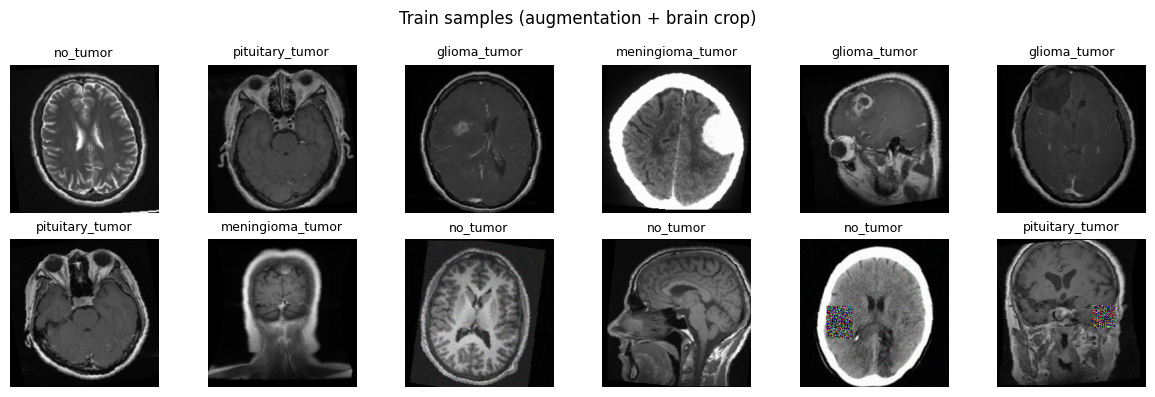

In [ ]:
# ============================================================
# 6) Dataset visualization
# ============================================================
def count_labels(ds_subset):
    ys = [int(ds_subset[i][1]) for i in range(len(ds_subset))]
    return np.bincount(np.array(ys), minlength=len(CLASSES))

train_counts = count_labels(train_ds)
val_counts   = count_labels(val_ds)

plt.figure(figsize=(7,3))
x = np.arange(len(CLASSES))
plt.bar(x - 0.2, train_counts, width=0.4, label="train")
plt.bar(x + 0.2, val_counts,   width=0.4, label="val")
plt.xticks(x, CLASSES, rotation=30, ha="right")
plt.title("Class counts (train/val)")
plt.legend()
plt.tight_layout()
plt.show()

def denorm(x):
    mean = torch.tensor(MEAN)[:,None,None]
    std  = torch.tensor(STD)[:,None,None]
    return (x.cpu()*std + mean).clamp(0,1)

xb, yb, _ = next(iter(train_loader))
n = min(12, xb.size(0))

plt.figure(figsize=(12,4))
for i in range(n):
    img = denorm(xb[i]).permute(1,2,0).numpy()
    plt.subplot(2,6,i+1)
    plt.imshow(img)
    plt.title(CLASSES[int(yb[i])], fontsize=9)
    plt.axis("off")
plt.suptitle("Train samples (augmentation + brain crop)")
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
# 7) Model: pretrained ResNet18 + multi-head outputs
# ============================================================
import torchvision

class MultiHeadResNet(nn.Module):
    def __init__(self, pretrained=True, dropout=0.25):
        super().__init__()
        weights = None
        if pretrained:
            try:
                weights = torchvision.models.ResNet18_Weights.DEFAULT
            except Exception:
                weights = None

        self.backbone = torchvision.models.resnet18(weights=weights)
        in_feats = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.dropout = nn.Dropout(dropout)
        self.det_head = nn.Linear(in_feats, 2)
        self.sub_head = nn.Linear(in_feats, 3)

    def forward(self, x):
        f = self.backbone(x)
        f = self.dropout(f)
        return self.det_head(f), self.sub_head(f)

model = MultiHeadResNet(pretrained=USE_PRETRAINED, dropout=0.25).to(device)

def set_backbone_trainable(trainable: bool, last_block_only=False):
    for p in model.backbone.parameters():
        p.requires_grad = trainable
    if trainable and last_block_only:
        for p in model.backbone.parameters():
            p.requires_grad = False
        for p in model.backbone.layer4.parameters():
            p.requires_grad = True

if USE_PRETRAINED and FREEZE_EPOCHS > 0:
    set_backbone_trainable(False)

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable/1e6:.2f}M / {total/1e6:.2f}M")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 195MB/s]


Trainable params: 0.00M / 11.18M


In [ ]:
# ============================================================
# 8) Compose 4-class distribution + losses
# ============================================================
def compose_logp4(det_logits, sub_logits):
    logp_det = F.log_softmax(det_logits, dim=1)  # (B,2) [no, tumor]
    logp_sub = F.log_softmax(sub_logits, dim=1)  # (B,3) [g,m,p]
    B = det_logits.size(0)
    logp4 = torch.empty((B, 4), device=det_logits.device, dtype=det_logits.dtype)
    logp4[:, 0] = logp_det[:, 1] + logp_sub[:, 0]
    logp4[:, 1] = logp_det[:, 1] + logp_sub[:, 1]
    logp4[:, 2] = logp_det[:, 1] + logp_sub[:, 2]
    logp4[:, 3] = logp_det[:, 0]
    return logp4

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction="mean"):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, logits, target):
        logp = F.log_softmax(logits, dim=1)
        p = logp.exp()
        idx = torch.arange(p.size(0), device=p.device)
        pt = p[idx, target]
        logpt = logp[idx, target]
        loss = -((1 - pt) ** self.gamma) * logpt
        if self.alpha is not None:
            loss = loss * self.alpha[target]
        if self.reduction == "mean":
            return loss.mean()
        if self.reduction == "sum":
            return loss.sum()
        return loss

def det_targets(y):
    return (y != NO_TUMOR_ID).long()

# weight tumor higher => fewer false negatives (better det recall)
det_alpha = torch.tensor([1.0, 1.5], device=device)
det_loss_fn = FocalLoss(gamma=2.0, alpha=det_alpha)

sub_loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)
SUB_MAP = {0:0, 1:1, 2:2}

def total_loss(det_logits, sub_logits, y, beta_sub=1.0):
    y = y.to(det_logits.device)
    loss_det = det_loss_fn(det_logits, det_targets(y))
    mask = (y != NO_TUMOR_ID)
    if mask.any():
        y_sub = torch.tensor([SUB_MAP[int(t.item())] for t in y[mask]], device=y.device)
        loss_sub = sub_loss_fn(sub_logits[mask], y_sub)
    else:
        loss_sub = det_logits.sum() * 0.0
    return loss_det + beta_sub * loss_sub


In [ ]:
# ============================================================
# 9) Evaluation helpers + visual outputs
# ============================================================
@torch.no_grad()
def forward_probs(model, x):
    det_logits, sub_logits = model(x)
    probs4 = compose_logp4(det_logits, sub_logits).exp()
    return probs4, det_logits, sub_logits

def predict_with_tau(probs4, tau):
    p_no = probs4[:, NO_TUMOR_ID]
    p_tum = 1.0 - p_no
    pred = probs4.argmax(1).clone()
    pred[p_tum < tau] = NO_TUMOR_ID
    return pred

@torch.no_grad()
def evaluate(model, loader, tau=0.5, return_details=False):
    model.eval()
    ys, ps, probs, paths = [], [], [], []
    for x, y, pth in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        pr, _, _ = forward_probs(model, x)
        pred = predict_with_tau(pr, tau)
        ys.append(y.cpu().numpy())
        ps.append(pred.cpu().numpy())
        probs.append(pr.cpu().numpy())
        paths += list(pth)

    y_true = np.concatenate(ys)
    y_pred = np.concatenate(ps)
    prob = np.concatenate(probs)

    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASSES))))
    acc = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

    prc, rcl, f1c, sup = precision_recall_fscore_support(
        y_true, y_pred, labels=list(range(len(CLASSES))), zero_division=0
    )
    per_class = pd.DataFrame({"class": CLASSES, "precision": prc, "recall": rcl, "f1": f1c, "support": sup})

    true_tumor = (y_true != NO_TUMOR_ID)
    pred_tumor = (y_pred != NO_TUMOR_ID)
    tp = int(np.sum(true_tumor & pred_tumor))
    fn = int(np.sum(true_tumor & ~pred_tumor))
    tn = int(np.sum(~true_tumor & ~pred_tumor))
    fp = int(np.sum(~true_tumor & pred_tumor))
    det_rec = tp / max(1, tp + fn)
    det_fp  = fp / max(1, fp + tn)

    out = {"acc": float(acc), "bacc": float(bacc), "macro_f1": float(macro_f1),
           "det_rec": float(det_rec), "det_fp": float(det_fp),
           "cm": cm, "per_class": per_class}
    if return_details:
        out.update({"y_true": y_true, "y_pred": y_pred, "probs": prob, "paths": paths})
    return out

def plot_confusion(cm, title):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick = np.arange(len(CLASSES))
    plt.xticks(tick, CLASSES, rotation=35, ha="right")
    plt.yticks(tick, CLASSES)
    thr = cm.max()/2.0 if cm.max() else 1.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i,j]), ha="center", va="center",
                     color="white" if cm[i,j] > thr else "black")
    plt.ylabel("True"); plt.xlabel("Pred")
    plt.tight_layout(); plt.show()

def plot_per_class_recall(df, title):
    plt.figure(figsize=(7,3))
    plt.bar(np.arange(len(df)), df["recall"].values)
    plt.xticks(np.arange(len(df)), df["class"].values, rotation=30, ha="right")
    plt.ylim(0, 1)
    plt.title(title)
    plt.tight_layout(); plt.show()


In [ ]:
# ============================================================
# 9b) Error targeting: normalized confusion + top confusions + mistake grid
# ============================================================
def plot_confusion_norm(cm, title, norm="true"):
    """
    norm="true" => rows sum to 1 (recall view)
    norm="pred" => cols sum to 1 (precision view)
    """
    cm = cm.astype(np.float32)
    if norm == "true":
        denom = cm.sum(axis=1, keepdims=True)
        cmn = cm / np.maximum(denom, 1e-8)
        subtitle = " (normalized by true label)"
    else:
        denom = cm.sum(axis=0, keepdims=True)
        cmn = cm / np.maximum(denom, 1e-8)
        subtitle = " (normalized by predicted label)"

    plt.figure(figsize=(6,5))
    plt.imshow(cmn, interpolation="nearest", vmin=0, vmax=1)
    plt.title(title + subtitle)
    plt.colorbar()
    tick = np.arange(len(CLASSES))
    plt.xticks(tick, CLASSES, rotation=35, ha="right")
    plt.yticks(tick, CLASSES)
    for i in range(cmn.shape[0]):
        for j in range(cmn.shape[1]):
            plt.text(j, i, f"{cmn[i,j]:.2f}", ha="center", va="center",
                     color="white" if cmn[i,j] > 0.5 else "black")
    plt.ylabel("True"); plt.xlabel("Pred")
    plt.tight_layout(); plt.show()

def top_confusions(cm, k=8):
    cm = cm.copy().astype(np.int64)
    pairs = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i == j:
                continue
            pairs.append((cm[i,j], i, j))
    pairs.sort(reverse=True)
    rows = []
    for n, i, j in pairs[:k]:
        rows.append({"count": int(n), "true": CLASSES[i], "pred": CLASSES[j]})
    return pd.DataFrame(rows)

def show_mistake_grid(details, max_images=18):
    y_true = details["y_true"]
    y_pred = details["y_pred"]
    paths = details["paths"]
    wrong = np.where(y_true != y_pred)[0]
    if len(wrong) == 0:
        print("No mistakes 🎉")
        return
    np.random.shuffle(wrong)
    wrong = wrong[:max_images]

    cols = 6
    rows = int(math.ceil(len(wrong)/cols))
    plt.figure(figsize=(3*cols, 3*rows))
    for i, idx in enumerate(wrong):
        img = Image.open(paths[idx]).convert("RGB")
        x = eval_tfms(img)
        x_den = denorm(x).permute(1,2,0).numpy()

        plt.subplot(rows, cols, i+1)
        plt.imshow(x_den)
        t = CLASSES[int(y_true[idx])]
        p = CLASSES[int(y_pred[idx])]
        plt.title(f"T:{t}\nP:{p}", fontsize=9)
        plt.axis("off")
    plt.suptitle("Random mistakes grid (denormalized, post-crop)")
    plt.tight_layout()
    plt.show()


In [ ]:
# ============================================================
# 10) Tune detection threshold τ on VAL only
# ============================================================
def sweep_tau(model, loader, taus=None):
    if taus is None:
        taus = np.linspace(0.05, 0.95, 19)
    rows = []
    for t in taus:
        m = evaluate(model, loader, tau=float(t))
        rows.append({"tau": float(t), "macro_f1": m["macro_f1"], "acc": m["acc"], "bacc": m["bacc"],
                     "det_rec": m["det_rec"], "det_fp": m["det_fp"]})
    df = pd.DataFrame(rows)
    best_tau = float(df.iloc[df["macro_f1"].values.argmax()]["tau"])
    return df, best_tau

df_tau, tau0 = sweep_tau(model, val_loader)
print("Best τ on VAL (untrained, just sanity):", tau0)
df_tau.head()


Best τ on VAL (untrained, just sanity): 0.7


,tau,macro_f1,acc,bacc,det_rec,det_fp
0,0.05,0.138327,0.194896,0.200451,0.508065,0.762712
1,0.10,0.138327,0.194896,0.200451,0.508065,0.762712
2,0.15,0.138327,0.194896,0.200451,0.508065,0.762712
3,0.20,0.138327,0.194896,0.200451,0.508065,0.762712
4,0.25,0.138327,0.194896,0.200451,0.508065,0.762712


In [ ]:
# ============================================================
# 11) Train loop (early stop on VAL macro_f1; Eval never used for selection)
# ============================================================
from contextlib import nullcontext
from tqdm.auto import tqdm

def make_optimizer():
    backbone_params = [p for p in model.backbone.parameters() if p.requires_grad]
    head_params = list(model.det_head.parameters()) + list(model.sub_head.parameters())
    groups = []
    if backbone_params:
        groups.append({"params": backbone_params, "lr": LR_BACKBONE})
    groups.append({"params": head_params, "lr": LR_HEAD})
    return torch.optim.AdamW(groups, weight_decay=WEIGHT_DECAY)

optimizer = make_optimizer()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

AMP_ENABLED = (device.type == "cuda")
if hasattr(torch, "amp") and hasattr(torch.amp, "autocast") and hasattr(torch.amp, "GradScaler"):
    autocast_ctx = (lambda: torch.amp.autocast("cuda", dtype=torch.float16)) if AMP_ENABLED else (lambda: nullcontext())
    scaler = torch.amp.GradScaler("cuda", enabled=AMP_ENABLED)
else:
    autocast_ctx = (lambda: torch.cuda.amp.autocast(enabled=AMP_ENABLED)) if AMP_ENABLED else (lambda: nullcontext())
    scaler = torch.cuda.amp.GradScaler(enabled=AMP_ENABLED)

def train_one_epoch(loader):
    model.train()
    total, n = 0.0, 0
    for x, y, _ in tqdm(loader, leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with autocast_ctx():
            det_logits, sub_logits = model(x)
            loss = total_loss(det_logits, sub_logits, y)

        if scaler.is_enabled():
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            if GRAD_CLIP is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            if GRAD_CLIP is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()

        bs = x.size(0)
        total += float(loss.detach().item()) * bs
        n += bs
    return total / max(1, n)

history = []
best = {"macro_f1": -1.0, "epoch": -1, "path": "/content/best_model.pt"}
no_improve = 0

EVAL_DURING_TRAIN = False  # for strict protocol

for epoch in range(1, EPOCHS + 1):
    # staged unfreeze
    if epoch == FREEZE_EPOCHS + 1 and USE_PRETRAINED:
        set_backbone_trainable(True, last_block_only=UNFREEZE_LAST_BLOCK_ONLY)
        optimizer = make_optimizer()
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, EPOCHS-epoch+1))
        print(f"[Unfreeze] epoch={epoch}: backbone trainable (last_block_only={UNFREEZE_LAST_BLOCK_ONLY})")

    if epoch == FREEZE_EPOCHS + 6 and USE_PRETRAINED and UNFREEZE_LAST_BLOCK_ONLY:
        set_backbone_trainable(True, last_block_only=False)
        optimizer = make_optimizer()
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, EPOCHS-epoch+1))
        print(f"[Unfreeze] epoch={epoch}: full backbone trainable")

    t0 = time.time()
    tr_loss = train_one_epoch(train_loader)

    # tune tau on val each epoch
    _, best_tau = sweep_tau(model, val_loader)
    val_m = evaluate(model, val_loader, tau=best_tau)

    elapsed = time.time() - t0
    row = {"epoch": epoch, "train_loss": tr_loss, "val_tau": best_tau,
           "val_macro_f1": val_m["macro_f1"], "val_acc": val_m["acc"], "val_bacc": val_m["bacc"],
           "val_det_rec": val_m["det_rec"], "val_det_fp": val_m["det_fp"]}
    history.append(row)

    print(
        f"Epoch {epoch:02d} | loss={tr_loss:.4f} | "
        f"val_macro_f1={val_m['macro_f1']:.3f} | val_acc={val_m['acc']:.3f} | "
        f"val_det_rec={val_m['det_rec']:.3f} | val_det_fp={val_m['det_fp']:.3f} | "
        f"tau={best_tau:.2f} | {elapsed:.1f}s"
    )

    if val_m["macro_f1"] > best["macro_f1"] + 1e-6:
        best["macro_f1"] = float(val_m["macro_f1"])
        best["epoch"] = epoch
        torch.save(model.state_dict(), best["path"])
        print(f"  ✅ saved new best: epoch={epoch}, macro_f1={best['macro_f1']:.3f}")
        no_improve = 0
    else:
        no_improve += 1

    scheduler.step()

    if no_improve >= PATIENCE:
        print(f"Early stop: no improvement for {PATIENCE} epochs. Best={best}")
        break

print("Best:", best)


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 01 | loss=1.2442 | val_macro_f1=0.479 | val_acc=0.508 | val_det_rec=0.793 | val_det_fp=0.305 | tau=0.05 | 95.6s
  ✅ saved new best: epoch=1, macro_f1=0.479


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 02 | loss=1.0397 | val_macro_f1=0.641 | val_acc=0.657 | val_det_rec=0.879 | val_det_fp=0.169 | tau=0.60 | 99.8s
  ✅ saved new best: epoch=2, macro_f1=0.641


  0%|          | 0/38 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbaf7751da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbaf7751da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 03 | loss=0.9465 | val_macro_f1=0.681 | val_acc=0.701 | val_det_rec=0.887 | val_det_fp=0.102 | tau=0.05 | 105.1s
  ✅ saved new best: epoch=3, macro_f1=0.681
[Unfreeze] epoch=4: backbone trainable (last_block_only=True)


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 04 | loss=0.8009 | val_macro_f1=0.756 | val_acc=0.766 | val_det_rec=0.941 | val_det_fp=0.102 | tau=0.05 | 105.4s
  ✅ saved new best: epoch=4, macro_f1=0.756


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 05 | loss=0.6653 | val_macro_f1=0.810 | val_acc=0.812 | val_det_rec=0.949 | val_det_fp=0.068 | tau=0.05 | 114.7s
  ✅ saved new best: epoch=5, macro_f1=0.810


  0%|          | 0/38 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbaf7751da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbaf7751da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 06 | loss=0.5735 | val_macro_f1=0.836 | val_acc=0.835 | val_det_rec=0.957 | val_det_fp=0.068 | tau=0.55 | 116.0s
  ✅ saved new best: epoch=6, macro_f1=0.836


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 07 | loss=0.5406 | val_macro_f1=0.858 | val_acc=0.854 | val_det_rec=0.978 | val_det_fp=0.085 | tau=0.05 | 96.3s
  ✅ saved new best: epoch=7, macro_f1=0.858


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 08 | loss=0.4998 | val_macro_f1=0.868 | val_acc=0.865 | val_det_rec=0.976 | val_det_fp=0.085 | tau=0.60 | 92.0s
  ✅ saved new best: epoch=8, macro_f1=0.868
[Unfreeze] epoch=9: full backbone trainable


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 09 | loss=0.4930 | val_macro_f1=0.865 | val_acc=0.868 | val_det_rec=0.952 | val_det_fp=0.034 | tau=0.05 | 101.7s


  0%|          | 0/38 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbaf7751da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^assert self._parent_pid == os.getpid(), 'can only test a child process'^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbaf7751da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 10 | loss=0.4442 | val_macro_f1=0.900 | val_acc=0.896 | val_det_rec=0.989 | val_det_fp=0.068 | tau=0.60 | 110.6s
  ✅ saved new best: epoch=10, macro_f1=0.900


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 11 | loss=0.4199 | val_macro_f1=0.907 | val_acc=0.905 | val_det_rec=0.987 | val_det_fp=0.068 | tau=0.60 | 95.2s
  ✅ saved new best: epoch=11, macro_f1=0.907


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 12 | loss=0.4017 | val_macro_f1=0.915 | val_acc=0.912 | val_det_rec=0.989 | val_det_fp=0.051 | tau=0.65 | 95.5s
  ✅ saved new best: epoch=12, macro_f1=0.915


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 13 | loss=0.3659 | val_macro_f1=0.923 | val_acc=0.919 | val_det_rec=0.989 | val_det_fp=0.034 | tau=0.05 | 93.1s
  ✅ saved new best: epoch=13, macro_f1=0.923


  0%|          | 0/38 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbaf7751da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbaf7751da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 14 | loss=0.3489 | val_macro_f1=0.929 | val_acc=0.926 | val_det_rec=0.987 | val_det_fp=0.017 | tau=0.05 | 119.7s
  ✅ saved new best: epoch=14, macro_f1=0.929


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 15 | loss=0.3452 | val_macro_f1=0.927 | val_acc=0.926 | val_det_rec=0.987 | val_det_fp=0.034 | tau=0.05 | 98.0s


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 16 | loss=0.3336 | val_macro_f1=0.938 | val_acc=0.933 | val_det_rec=0.995 | val_det_fp=0.017 | tau=0.05 | 93.3s
  ✅ saved new best: epoch=16, macro_f1=0.938


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 17 | loss=0.3336 | val_macro_f1=0.939 | val_acc=0.933 | val_det_rec=0.995 | val_det_fp=0.000 | tau=0.05 | 92.7s
  ✅ saved new best: epoch=17, macro_f1=0.939


  0%|          | 0/38 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbaf7751da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bbaf7751da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

KeyboardInterrupt: 

,epoch,train_loss,val_tau,val_macro_f1,val_acc,val_bacc,val_det_rec,val_det_fp
7,8,0.499848,0.60,0.867867,0.865429,0.871959,0.975806,0.084746
8,9,0.493038,0.05,0.864978,0.867749,0.880638,0.951613,0.033898
9,10,0.444238,0.60,0.899970,0.895592,0.900390,0.989247,0.067797
10,11,0.419889,0.60,0.907062,0.904872,0.908454,0.986559,0.067797
11,12,0.401678,0.65,0.915328,0.911833,0.916724,0.989247,0.050847
12,13,0.365913,0.05,0.922594,0.918794,0.924993,0.989247,0.033898
13,14,0.348949,0.05,0.928620,0.925754,0.933263,0.986559,0.016949
14,15,0.345233,0.05,0.927294,0.925754,0.931042,0.986559,0.033898
15,16,0.333607,0.05,0.937945,0.932715,0.939311,0.994624,0.016949
16,17,0.333558,0.05,0.938887,0.932715,0.941532,0.994624,0.000000


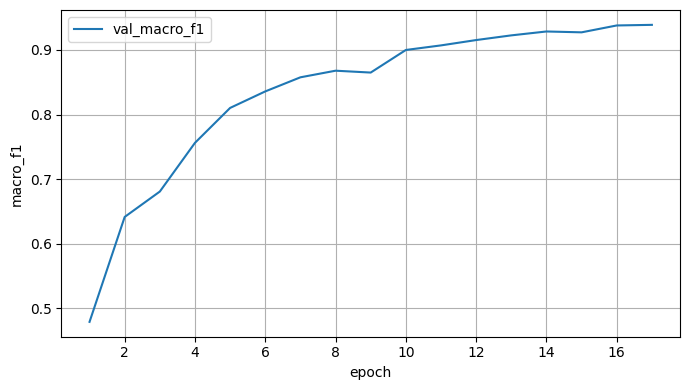

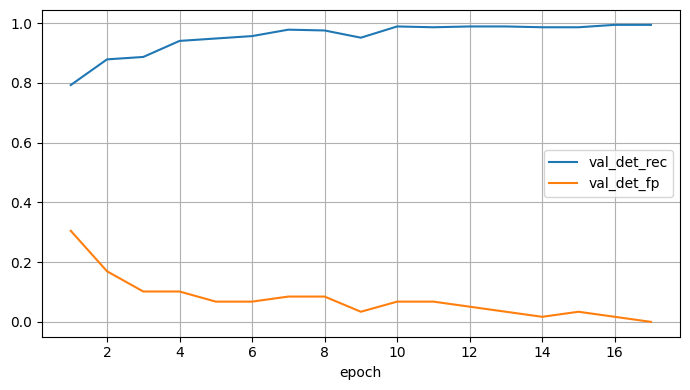

In [ ]:
# ============================================================
# 12) Plot training curves
# ============================================================
hist = pd.DataFrame(history)
display(hist.tail(10))

plt.figure(figsize=(7,4))
plt.plot(hist["epoch"], hist["val_macro_f1"], label="val_macro_f1")
plt.xlabel("epoch"); plt.ylabel("macro_f1"); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(hist["epoch"], hist["val_det_rec"], label="val_det_rec")
plt.plot(hist["epoch"], hist["val_det_fp"], label="val_det_fp")
plt.xlabel("epoch"); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()


Chosen τ (from VAL): 0.05
VAL : {'acc': 0.9327146171693735, 'bacc': 0.9415322580645162, 'macro_f1': 0.9388865986096284, 'det_rec': 0.9946236559139785, 'det_fp': 0.0}
TEST: {'acc': 0.6979695431472082, 'bacc': 0.6811636170331823, 'macro_f1': 0.6835265302061315, 'det_rec': 0.7681660899653979, 'det_fp': 0.0380952380952381}


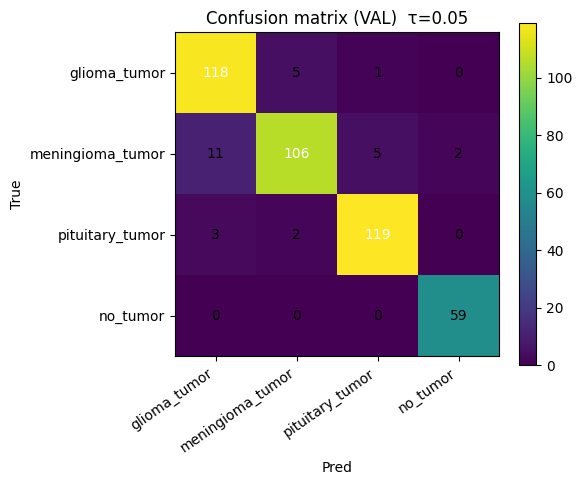

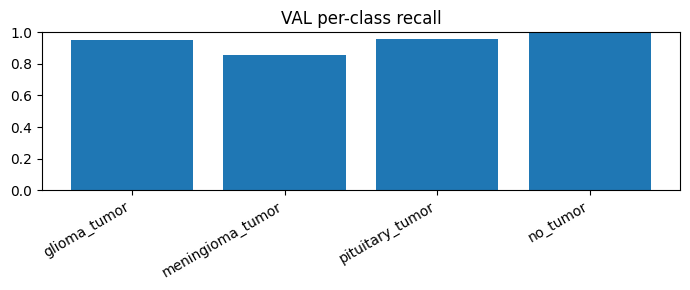

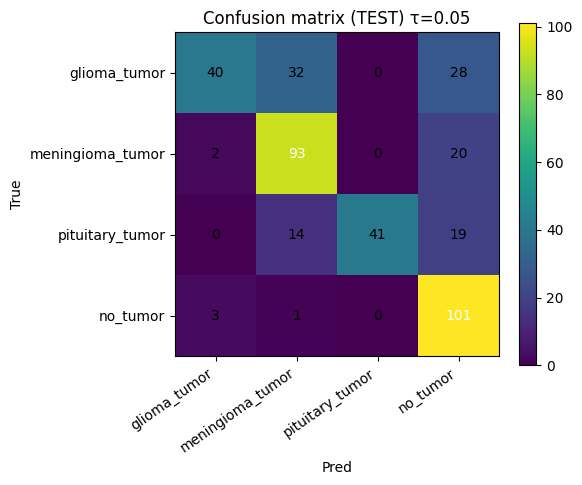

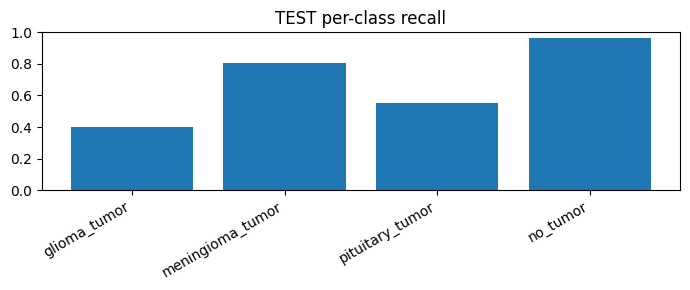


Classification report (TEST):

                  precision    recall  f1-score   support

    glioma_tumor       0.89      0.40      0.55       100
meningioma_tumor       0.66      0.81      0.73       115
 pituitary_tumor       1.00      0.55      0.71        74
        no_tumor       0.60      0.96      0.74       105

        accuracy                           0.70       394
       macro avg       0.79      0.68      0.68       394
    weighted avg       0.77      0.70      0.68       394



In [ ]:
# ============================================================
# 13) Final evaluation on TEST + external EVAL (clean protocol)
# ============================================================
model.load_state_dict(torch.load(best["path"], map_location=device))
model.eval()

_, best_tau = sweep_tau(model, val_loader)
print("Chosen τ (from VAL):", best_tau)

val_m = evaluate(model, val_loader, tau=best_tau)
test_m = evaluate(model, test_loader, tau=best_tau, return_details=True)

print("VAL :", {k: val_m[k] for k in ["acc","bacc","macro_f1","det_rec","det_fp"]})
print("TEST:", {k: test_m[k] for k in ["acc","bacc","macro_f1","det_rec","det_fp"]})

plot_confusion(val_m["cm"],  f"Confusion matrix (VAL)  τ={best_tau:.2f}")
plot_per_class_recall(val_m["per_class"], "VAL per-class recall")

plot_confusion(test_m["cm"], f"Confusion matrix (TEST) τ={best_tau:.2f}")
plot_per_class_recall(test_m["per_class"], "TEST per-class recall")

print("\nClassification report (TEST):\n")
print(classification_report(test_m["y_true"], test_m["y_pred"], target_names=CLASSES, zero_division=0))

eval_m = None
if eval_loader is not None:
    eval_m = evaluate(model, eval_loader, tau=best_tau, return_details=True)
    print("EVAL:", {k: eval_m[k] for k in ["acc","bacc","macro_f1","det_rec","det_fp"]})
    plot_confusion(eval_m["cm"], f"Confusion matrix (EVAL external) τ={best_tau:.2f}")
    plot_per_class_recall(eval_m["per_class"], "EVAL per-class recall")
    print("\nClassification report (EVAL):\n")
    print(classification_report(eval_m["y_true"], eval_m["y_pred"], target_names=CLASSES, zero_division=0))


,class,precision_old,recall_old,f1_old,support_old,precision_new,recall_new,f1_new,support_new
0,glioma_tumor,0.73,0.19,0.30,100,0.888889,0.400000,0.551724,100
1,meningioma_tumor,0.56,0.50,0.53,115,0.664286,0.808696,0.729412,115
2,no_tumor,0.46,0.91,0.61,105,0.601190,0.961905,0.739927,105
3,pituitary_tumor,0.59,0.45,0.51,74,1.000000,0.554054,0.713043,74


,class,precision_old,precision_new,precision_delta,recall_old,recall_new,recall_delta,f1_old,f1_new,f1_delta
0,glioma_tumor,0.73,0.888889,0.158889,0.19,0.400000,0.210000,0.30,0.551724,0.251724
1,meningioma_tumor,0.56,0.664286,0.104286,0.50,0.808696,0.308696,0.53,0.729412,0.199412
2,no_tumor,0.46,0.601190,0.141190,0.91,0.961905,0.051905,0.61,0.739927,0.129927
3,pituitary_tumor,0.59,1.000000,0.410000,0.45,0.554054,0.104054,0.51,0.713043,0.203043


Top TEST confusions (new):


,count,true,pred
0,32,glioma_tumor,meningioma_tumor
1,28,glioma_tumor,no_tumor
2,20,meningioma_tumor,no_tumor
3,19,pituitary_tumor,no_tumor
4,14,pituitary_tumor,meningioma_tumor
5,3,no_tumor,glioma_tumor
6,2,meningioma_tumor,glioma_tumor
7,1,no_tumor,meningioma_tumor
8,0,no_tumor,pituitary_tumor
9,0,pituitary_tumor,glioma_tumor


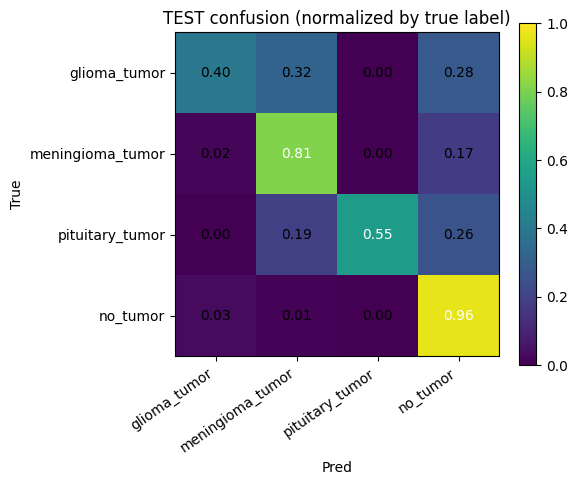

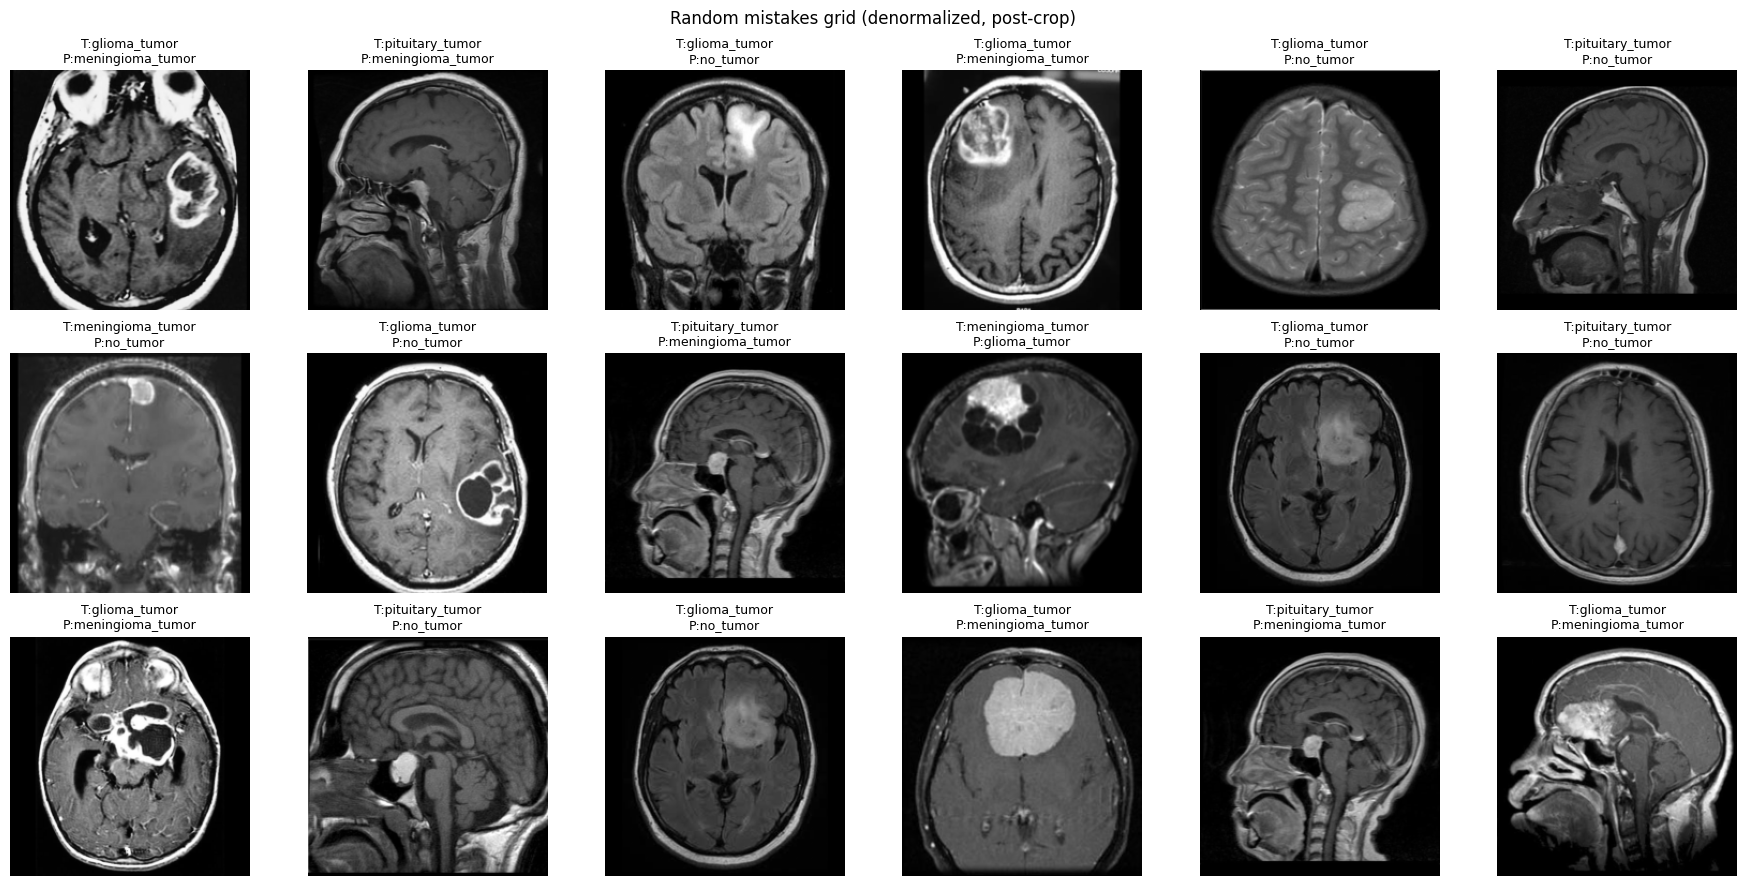

In [ ]:
# ============================================================
# 13b) Compare against a previous run (fill in old metrics here)
# ============================================================
# Paste/adjust your old per-class metrics here (example values from your earlier report).
old = pd.DataFrame({
    "class": ["glioma_tumor","meningioma_tumor","pituitary_tumor","no_tumor"],
    "precision_old": [0.73, 0.56, 0.59, 0.46],
    "recall_old":    [0.19, 0.50, 0.45, 0.91],
    "f1_old":        [0.30, 0.53, 0.51, 0.61],
    "support_old":   [100, 115, 74, 105],
})

# current per-class
cur = (test_m["per_class"]
       .rename(columns={"precision":"precision_new","recall":"recall_new","f1":"f1_new","support":"support_new"})
       .copy())

cmp = old.merge(cur, on="class", how="outer").fillna(np.nan)
display(cmp)

# delta view
for col in ["precision","recall","f1"]:
    cmp[f"{col}_delta"] = cmp[f"{col}_new"] - cmp[f"{col}_old"]
display(cmp[["class","precision_old","precision_new","precision_delta",
             "recall_old","recall_new","recall_delta",
             "f1_old","f1_new","f1_delta"]])

# Also compare confusion top errors (new)
print("Top TEST confusions (new):")
display(top_confusions(test_m["cm"], k=10))
plot_confusion_norm(test_m["cm"], "TEST confusion", norm="true")
show_mistake_grid(test_m, max_images=18)

if eval_m is not None:
    print("Top EVAL confusions (new):")
    display(top_confusions(eval_m["cm"], k=10))
    plot_confusion_norm(eval_m["cm"], "EVAL confusion", norm="true")
    show_mistake_grid(eval_m, max_images=18)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# ---- Helper: find last Conv2d in the model (robust across architectures) ----
def _get_last_conv2d(model: nn.Module) -> nn.Conv2d:
    last = None
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            last = m
    if last is None:
        raise RuntimeError("No Conv2d layer found for Grad-CAM.")
    return last

# ---- Grad-CAM implementation (no external deps) ----
class SimpleGradCAM:
    def __init__(self, model: nn.Module, target_layer: nn.Module):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self._h1 = target_layer.register_forward_hook(self._save_act)
        self._h2 = target_layer.register_full_backward_hook(self._save_grad)

    def _save_act(self, module, inp, out):
        self.activations = out

    def _save_grad(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def close(self):
        self._h1.remove()
        self._h2.remove()

    def __call__(self, x, score_scalar):
        """
        x: input tensor [1,C,H,W]
        score_scalar: scalar tensor that requires grad (e.g. logp4[0, cls])
        """
        self.model.zero_grad(set_to_none=True)
        score_scalar.backward(retain_graph=False)

        if self.activations is None or self.gradients is None:
            raise RuntimeError("Hooks did not capture activations/gradients. Check target layer selection.")

        # Grad-CAM: global-average-pool gradients over spatial dims
        grads = self.gradients  # [1, C, h, w]
        acts  = self.activations  # [1, C, h, w]
        weights = grads.mean(dim=(2,3), keepdim=True)  # [1, C, 1, 1]
        cam = (weights * acts).sum(dim=1, keepdim=False)  # [1, h, w]
        cam = F.relu(cam)

        # Normalize to [0,1]
        cam = cam[0]
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        return cam.detach().cpu().numpy()

# ---- Compose 4-class log-probs from your multi-head outputs ----
def compose_logp4(det_logits, sub_logits, classes):
    # expects det_logits [B,2] (no,tumor), sub_logits [B,3]
    no_id = classes.index("no_tumor")
    tumor_class_ids = [i for i in range(len(classes)) if i != no_id]

    det_logp = F.log_softmax(det_logits.float(), dim=1)   # [B,2]
    logp_no = det_logp[:, 0]                              # [B]
    logp_tu = det_logp[:, 1]                              # [B]
    sub_logp = F.log_softmax(sub_logits.float(), dim=1)   # [B,3]

    logp_tumor_types = logp_tu[:, None] + sub_logp        # [B,3]
    logp4 = torch.cat([logp_tumor_types, logp_no[:, None]], dim=1)  # [B,4]
    return logp4, tumor_class_ids, no_id

# ---- Overlay utility ----
def _to_uint8_img(x_tensor, mean, std):
    # x_tensor: [1,C,H,W] normalized
    x = x_tensor[0].detach().cpu()
    x = x * torch.tensor(std)[:, None, None] + torch.tensor(mean)[:, None, None]
    x = x.clamp(0, 1)
    x = (x.permute(1,2,0).numpy() * 255).astype(np.uint8)
    return x

def show_explanations(metrics_dict, n=3, tau=0.5, only_mistakes=True):
    """
    metrics_dict should contain:
      - 'model': model
      - 'loader': dataloader
      - 'classes': list of class names
      - 'mean','std': normalization stats
    """
    model = metrics_dict["model"]
    loader = metrics_dict["loader"]
    classes = metrics_dict["classes"]
    mean = metrics_dict["mean"]
    std = metrics_dict["std"]

    device = next(model.parameters()).device
    model.eval()

    # IMPORTANT: Grad-CAM needs grads ON (even in eval mode)
    torch.set_grad_enabled(True)
    for p in model.parameters():
        p.requires_grad_(True)

    target_conv = _get_last_conv2d(model)
    cam = SimpleGradCAM(model, target_conv)

    shown = 0
    with torch.enable_grad():  # <-- this is the key fix vs your error
        for batch in loader:
            # support datasets that return (x,y) or (x,y,extra)
            x = batch[0].to(device, non_blocking=True)
            y = batch[1].to(device, non_blocking=True)

            # do single examples to keep it simple
            for i in range(x.size(0)):
                xi = x[i:i+1]
                yi = y[i].item()

                det_logits, sub_logits = model(xi)  # MUST NOT be under no_grad/inference_mode
                logp4, tumor_class_ids, no_id = compose_logp4(det_logits, sub_logits, classes)

                # thresholded decision (tumor vs no_tumor), then subtype if tumor
                det_p = torch.softmax(det_logits.float(), dim=1)[0,1]  # p(tumor)
                sub_idx = int(sub_logits.argmax(1).item())             # 0..2

                if float(det_p.item()) >= float(tau):
                    pred = tumor_class_ids[sub_idx]
                else:
                    pred = no_id

                if only_mistakes and (pred == yi):
                    continue

                # scalar score for Grad-CAM: use log-prob of predicted class (requires grad)
                score = logp4[0, pred]  # scalar with grad_fn

                heat = cam(xi, score)  # [h,w] numpy
                img = _to_uint8_img(xi, mean, std)

                plt.figure(figsize=(5,5))
                plt.imshow(img)
                plt.imshow(heat, alpha=0.45)  # default colormap
                plt.axis("off")
                plt.title(f"true={classes[yi]} | pred={classes[pred]} | p_tumor={float(det_p):.3f}")
                plt.show()

                shown += 1
                if shown >= n:
                    cam.close()
                    return

    cam.close()

In [ ]:
# You likely already have these in your notebook:
# model, test_loader, CLASSES, mean, std, best_tau

show_explanations(model, n=3, tau=best_tau, only_mistakes=True)

TypeError: 'MultiHeadResNet' object is not subscriptable

## Data is likely a limiting factor

With only ~800 images per tumor subtype, performance can be limited by:
- scan protocol differences (contrast, slice thickness)
- dataset shortcuts (borders, text, windowing)
- label noise / ambiguous slices

Below is an **optional** learning-curve-like probe: it trains *only the heads* for a few epochs with the backbone frozen, using different train fractions, to see whether more data still improves validation macro-F1.


In [ ]:
# ============================================================
# 15) OPTIONAL: learning-curve probe (heads-only, short)
# ============================================================
from contextlib import nullcontext

def make_subsample_loader(train_fraction):
    idx = np.array(train_idx)
    y = y_all[idx]
    sss2 = StratifiedShuffleSplit(n_splits=1, train_size=train_fraction, random_state=SEED)
    sub_idx, _ = next(sss2.split(np.zeros(len(y)), y))
    ds = Subset(train_ds_full, idx[sub_idx])
    return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS,
                      pin_memory=(device.type=="cuda"), drop_last=True, persistent_workers=False, collate_fn=_collate)

def probe_fraction(frac, epochs=3):
    m = MultiHeadResNet(pretrained=USE_PRETRAINED, dropout=0.25).to(device)
    for p in m.backbone.parameters():
        p.requires_grad = False
    opt = torch.optim.AdamW(list(m.det_head.parameters()) + list(m.sub_head.parameters()),
                            lr=LR_HEAD, weight_decay=WEIGHT_DECAY)

    AMP = (device.type == "cuda")
    if hasattr(torch, "amp") and hasattr(torch.amp, "autocast"):
        ac = (lambda: torch.amp.autocast("cuda", dtype=torch.float16)) if AMP else (lambda: nullcontext())
        sc = torch.amp.GradScaler("cuda", enabled=AMP)
    else:
        ac = (lambda: torch.cuda.amp.autocast(enabled=AMP)) if AMP else (lambda: nullcontext())
        sc = torch.cuda.amp.GradScaler(enabled=AMP)

    loader = make_subsample_loader(frac)
    for _ in range(epochs):
        m.train()
        for x,y,_p in loader:
            x = x.to(device); y = y.to(device)
            opt.zero_grad(set_to_none=True)
            with ac():
                det_logits, sub_logits = m(x)
                loss = total_loss(det_logits, sub_logits, y)
            if sc.is_enabled():
                sc.scale(loss).backward()
                sc.step(opt); sc.update()
            else:
                loss.backward(); opt.step()

    _, tau_best = sweep_tau(m, val_loader)
    vm = evaluate(m, val_loader, tau=tau_best)
    return vm["macro_f1"], vm["det_rec"]

fractions = [0.2, 0.4, 0.6, 0.8, 1.0]
rows = []
for f in fractions:
    mf1, drec = probe_fraction(f, epochs=3)
    rows.append({"train_fraction": f, "val_macro_f1": mf1, "val_det_rec": drec})
    print(rows[-1])

probe = pd.DataFrame(rows)
plt.figure(figsize=(6,4))
plt.plot(probe["train_fraction"], probe["val_macro_f1"], marker="o")
plt.xlabel("train fraction"); plt.ylabel("val macro_f1")
plt.grid(True); plt.tight_layout(); plt.show()
display(probe)


{'train_fraction': 0.2, 'val_macro_f1': 0.43601100875624565, 'val_det_rec': 0.8091397849462365}


KeyboardInterrupt: 

In [ ]:
import shutil

# Source path of the best model
source_path = "/content/best_model.pt"

# Destination path in Google Drive
drive_path = "/content/drive/MyDrive/best_model.pt"

try:
    shutil.copy(source_path, drive_path)
    print(f"Successfully copied '{source_path}' to '{drive_path}'")
except Exception as e:
    print(f"Error copying file: {e}")

In [ ]:
from google.colab import files
files.download('best_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>